
# Machine learning project 1 regression on `Delays` dataset
## Predicting total delay upon arrival

### Authors:
- Assyl Salah
- Ayetijhya Desmukhya 


# Table of Contents

1. Introduction
    - Goal of the project
    - Economic background
    - Dataset description
    
2. Data cleaning and preprocessing 
    - Transforming dataset variables 
    - Removing outliers 
    - Checking for missing values and imputing missing values

3. Regression models

4. Conclusion

5. References

## Introduction

Air travel serves as a fundamental link for individuals and businesses worldwide. Nonetheless, flight disruptions, such as delays, can disrupt passenger plans, impact travel itineraries, and incur expenses for airlines and travelers alike. Hence, grasping and anticipating flight delays holds immense significance for both airlines and passengers, allowing them to navigate and minimize the disruptive consequences associated with such occurrences.



### Economic background

Flight delays can carry considerable financial impact. For airlines, such delays frequently drive up operational expenses, encompassing heightened fuel consumption, crew salaries, and maintenance outlays. Moreover, they can lead to postponed connections, potentially leading to compensatory measures for passengers or business setbacks. Additionally, travelers might face supplementary expenses stemming from canceled appointments, lodging expenses, or transfer charges. Furthermore, these delays hold the capacity to disrupt broader economic channels, delaying corporate engagements and  impairing productivity. Hence, prediction and handling of flight delays stand as imperative measures to curtail monetary setbacks and uphold the seamless functioning of air travel infrastructures.

### Goal of the project
The aim of this project is to employ various machine learning regression algorithms to develop a model that is capable of forecasting flight arrival delays using features like day of the week, month, departure and arrival times, airline, weather conditions, and others. By achieving accurate predictions of flight delays, airlines can enhance schedule management, mitigate disturbances, and elevate customer contentment. Likewise, travelers can strategize their journeys more effectively, thereby alleviating the anxiety and inconvenience caused by unforeseen delays. The regression models will be assessed using the **Mean Absolute Percentage Error (MAPE)**.


### Data Description


The dataset includes `1631327` observations and `28` variables in the training sample an `407832` and `27` variables in the test sample and the following columns:

- Weekday – Day of the week when the flight occurred (1 for Sunday, 7 for Saturday).
- Month_of_Year – The numerical month (1-12) when the flight took place.
- Day_of_Month – The day of the month (1-31) when the flight occurred.
- Scheduled_Departure_Time – The scheduled local time of flight departure.
- Scheduled_Arrival_Time – The scheduled local time of flight arrival.
- Marketing_Airline – The airline code under which the flight was marketed.
- Marketing_Airline_DOT_ID – Department of Transportation identifier for the marketing airline.
- Flight_Number – The number assigned to the flight by the operating airline.
- Origin_Airport_ID – Unique identifier for the departure airport.
- Destination_Airport_ID – Unique identifier for the arrival airport.
- Flight_Cancelled – Indicator of whether the flight was cancelled (1 = Yes, 0 = No).
- Departure_State – The state code of the departure location.
- Arrival_State – The state code of the arrival location.
- Departure_Delay – Total delay in minutes at departure.
- Diverted_Airport_Landings – Count of unplanned landings at other airports.
- Taxi_Out_Time – Time in minutes from gate departure until takeoff.
- Taxi_In_Time – Time in minutes from landing to gate arrival.
- Flight_Diverted – Indicator of whether the flight was diverted (1 = Yes, 0 = No).
- Actual_Departure_Time – The actual local time the flight departed.
- Flight_Duration – The duration of the flight in minutes from takeoff to landing.
- Flight_Distance – The total distance covered by the flight in miles.
- Origin_Temperature – The temperature at the origin airport at the time of the flight’s departure.
- Destination_Temperature – The temperature at the destination airport at the time of the flight’s arrival.
- Origin_Wind_Speed – The wind speed at the origin airport during the departure of the flight.
- Destination_Wind_Speed – The wind speed at the destination airport during the departure of the flight.
- Origin_Precipitation – The amount of precipitation, such as rain or snow, at the origin airport around the flight’s departure time.
- Destination_Precipitation – The amount of precipitation, such as rain or snow, at the destination airport around the flight’s arrival time.
- Arrival_Delay – Total delay in minutes at arrival (outcome variable, only in the training sample)

## Dependencies loading

In [173]:
# Data preprocessing and visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scaling
from sklearn.preprocessing import StandardScaler

# Splitting train and validation dataset, cross validating and grid search 
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV,RandomizedSearchCV

# Regression models
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.linear_model import (
    LinearRegression,
    Lasso,
    Ridge,
    ElasticNet
)
# Calculating MAPE
from sklearn.metrics import mean_absolute_percentage_error

# Chi-square test for categorical variables
from scipy.stats import chi2_contingency


# Enconding of cateogrical data based on target variable
import category_encoders as ce

## Data loading

In [136]:
def read_gzipped_csv(gzipped_csv_file):
    df = pd.read_csv(gzipped_csv_file, compression='gzip')
    return df

train_data = read_gzipped_csv('data/delays_train.csv.gz')
test_data = read_gzipped_csv('data/delays_test.csv.gz')
# train_data = pd.read_csv('data\delays_train.csv')
# test_data = pd.read_csv('data\delays_test.csv')

## Data overview 

### Train data 

In [137]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1631327 entries, 0 to 1631326
Data columns (total 28 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Weekday                    1631327 non-null  int64  
 1   Month_of_Year              1631327 non-null  int64  
 2   Day_of_Month               1631327 non-null  int64  
 3   Scheduled_Departure_Time   1631327 non-null  int64  
 4   Scheduled_Arrival_Time     1631327 non-null  int64  
 5   Marketing_Airline          1467776 non-null  object 
 6   Marketing_Airline_DOT_ID   1631327 non-null  int64  
 7   Flight_Number              1631327 non-null  int64  
 8   Origin_Airport_ID          1631327 non-null  int64  
 9   Destination_Airport_ID     1468233 non-null  float64
 10  Flight_Cancelled           1631327 non-null  bool   
 11  Departure_State            1631327 non-null  object 
 12  Arrival_State              1631327 non-null  object 
 13  Departure_De

In [138]:
train_data.head()

,Weekday,Month_of_Year,Day_of_Month,Scheduled_Departure_Time,Scheduled_Arrival_Time,Marketing_Airline,Marketing_Airline_DOT_ID,Flight_Number,Origin_Airport_ID,Destination_Airport_ID,...,Flight_Diverted,Actual_Departure_Time,Flight_Duration,Flight_Distance,Origin_Temperature,Destination_Temperature,Origin_Wind_Speed,Destination_Wind_Speed,Origin_Precipitation,Destination_Precipitation
0,6,6,25,1222,1444,B6,20409,520,10397,12478.0,...,False,1224.0,107.0,760.0,25.140220,19.357739,21.019808,15.452723,0.0,0.0
1,2,6,21,1216,1304,NaN,19805,6297,14107,15376.0,...,False,1216.0,23.0,110.0,13.279939,20.470690,18.045064,12.910265,0.0,0.0
2,3,1,5,1945,2055,DL,19790,4124,13487,13076.0,...,False,1945.0,36.0,119.0,17.816202,13.967273,21.606228,17.976362,0.0,0.1
3,2,3,22,700,924,AA,19805,1538,15624,11298.0,...,False,658.0,125.0,641.0,24.562566,14.509228,24.946489,22.630553,0.0,0.0
4,4,7,14,2130,2359,NaN,19930,1116,14747,12889.0,...,False,2133.0,130.0,867.0,8.817992,10.866812,17.426336,17.401007,0.0,0.0


In [139]:
round(train_data.describe().T,2)

,count,mean,std,min,25%,50%,75%,max
Weekday,1631327.0,4.01,2.01,1.00,2.00,4.00,6.00,7.00
Month_of_Year,1631327.0,4.08,2.00,1.00,2.00,4.00,6.00,7.00
Day_of_Month,1631327.0,15.72,8.76,1.00,8.00,16.00,23.00,31.00
Scheduled_Departure_Time,1631327.0,1329.79,490.39,1.00,915.00,1320.00,1735.00,2359.00
Scheduled_Arrival_Time,1631327.0,1486.05,518.65,1.00,1103.00,1512.00,1920.00,2359.00
Marketing_Airline_DOT_ID,1631327.0,19830.81,276.15,19393.00,19790.00,19805.00,19977.00,20436.00
Flight_Number,1631327.0,2561.29,1745.16,1.00,1106.00,2228.00,3874.00,9680.00
Origin_Airport_ID,1631327.0,12660.01,1522.94,10135.00,11292.00,12889.00,14027.00,16869.00
Destination_Airport_ID,1468233.0,12658.28,1521.78,10135.00,11292.00,12889.00,14027.00,16869.00
Departure_Delay,1424866.0,13.11,53.96,-78.33,-5.08,-1.57,10.71,7223.21


From the summary statistics, it's notable that the numerical variables have different scales. Some variables show relatively small ranges, like Origin_Precipitation, while others, such as Flight_Distance and Flight_Duration, have much wider ranges. It's beneficial  to scale these variables before using regression to prevent their magnitudes from unnecessary impacting the model's outcomes. This scaling process helps ensure that all variables contribute evenly and fairly to the regression analysis, irrespective of their original scales.

- `Weekday and Month_of_Year:` Both demonstrate a similar distribution, with mean values clustered around the middle of their respective ranges. This suggests a relatively even distribution of flights across weekdays and months.

- `Day_of_Month:` The mean and median values closely align with the midpoint of the month, indicating a fairly uniform distribution of flights throughout the month.

- `Scheduled_Departure_Time and Scheduled_Arrival_Time:` Present a broad range of scheduled departure and arrival times, highlighting significant variability in scheduling.

- `Marketing_Airline_DOT_ID and Flight_Number:` Show considerable dispersion, indicating a wide range of identification numbers for airlines and flight numbers.

- `Departure_Delay and Arrival_Delay:` Both exhibit positive means, indicating that flights, on average, experience delays. However, the relatively high standard deviations suggest notable variability in delay durations.

- `Diverted_Airport_Landings:` Suggests that the majority of flights do not undergo diversions, as evidenced by the mean value nearing zero.

- `Taxi_Out_Time and Taxi_In_Time:` Demonstrate moderate variability, with relatively brief average taxi durations.

- `Flight_Duration and Flight_Distance:` Show a diverse range of values, reflecting variations in flight durations and distances covered.

- `Origin_Temperature and Destination_Temperature:` Reflect moderate temperature ranges at both origin and destination airports, with mean values hovering around 16-17 degrees Celsius.

- `Origin_Wind_Speed and Destination_Wind_Speed:` Indicate moderate wind speeds at both origin and destination airports, with mean values approximately around 20 km/h.

- `Origin_Precipitation and Destination_Precipitation:` Present low mean values, signifying generally limited levels of precipitation at both origin and destination airports.

In [140]:
train_data.isnull().sum()

Weekday                           0
Month_of_Year                     0
Day_of_Month                      0
Scheduled_Departure_Time          0
Scheduled_Arrival_Time            0
Marketing_Airline            163551
Marketing_Airline_DOT_ID          0
Flight_Number                     0
Origin_Airport_ID                 0
Destination_Airport_ID       163094
Flight_Cancelled                  0
Departure_State                   0
Arrival_State                     0
Departure_Delay              206461
Arrival_Delay                211306
Diverted_Airport_Landings         0
Taxi_Out_Time                 49225
Taxi_In_Time                  49867
Flight_Diverted                   0
Actual_Departure_Time         48326
Flight_Duration              211490
Flight_Distance              163190
Origin_Temperature           163190
Destination_Temperature      163190
Origin_Wind_Speed            211490
Destination_Wind_Speed       211490
Origin_Precipitation              0
Destination_Precipitation   

Based on the count of missing values in each variable, it can be seen that several variables have missing values, including Marketing_Airline, Destination_Airport_ID, Departure_Delay, Arrival_Delay, and so on. Therefore, it is necessary to consider data imputation techniques to fill in these missing values before applying regression models to ensure complete and reliable analysis.

In [141]:
train_data.shape

(1631327, 28)

### Test data 

In [142]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 407832 entries, 0 to 407831
Data columns (total 27 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Weekday                    407832 non-null  int64  
 1   Month_of_Year              407832 non-null  int64  
 2   Day_of_Month               407832 non-null  int64  
 3   Scheduled_Departure_Time   407832 non-null  int64  
 4   Scheduled_Arrival_Time     407832 non-null  int64  
 5   Marketing_Airline          367468 non-null  object 
 6   Marketing_Airline_DOT_ID   407832 non-null  int64  
 7   Flight_Number              407832 non-null  int64  
 8   Origin_Airport_ID          407832 non-null  int64  
 9   Destination_Airport_ID     367011 non-null  float64
 10  Flight_Cancelled           407832 non-null  bool   
 11  Departure_State            407832 non-null  object 
 12  Arrival_State              407832 non-null  object 
 13  Departure_Delay            35

In [143]:
test_data.head()

,Weekday,Month_of_Year,Day_of_Month,Scheduled_Departure_Time,Scheduled_Arrival_Time,Marketing_Airline,Marketing_Airline_DOT_ID,Flight_Number,Origin_Airport_ID,Destination_Airport_ID,...,Flight_Diverted,Actual_Departure_Time,Flight_Duration,Flight_Distance,Origin_Temperature,Destination_Temperature,Origin_Wind_Speed,Destination_Wind_Speed,Origin_Precipitation,Destination_Precipitation
0,2,5,10,820,1011,AA,19805,4808,12478,14492.0,...,False,819.0,64.0,427.0,11.274087,16.012261,17.332261,24.629961,0.0,0.0
1,3,3,9,526,655,NaN,19790,3688,14489,14747.0,...,False,524.0,53.0,228.0,4.967302,18.358241,17.795975,15.307041,0.0,0.0
2,3,3,9,1651,1943,DL,19790,1713,14635,11433.0,...,False,1705.0,134.0,1084.0,18.483917,16.467901,18.704558,17.468001,0.0,0.0
3,5,4,15,1133,1245,UA,19977,4712,11298,11292.0,...,False,1146.0,107.0,641.0,12.932652,18.790894,14.105251,25.659088,2.0,1.0
4,3,5,11,1507,1752,NK,20416,1399,11618,13204.0,...,False,1737.0,125.0,937.0,18.982421,15.382372,22.579627,19.144705,0.0,0.0


In [144]:
round(test_data.describe().T,2)

,count,mean,std,min,25%,50%,75%,max
Weekday,407832.0,4.01,2.01,1.00,2.00,4.00,6.00,7.00
Month_of_Year,407832.0,4.09,2.00,1.00,2.00,4.00,6.00,7.00
Day_of_Month,407832.0,15.73,8.76,1.00,8.00,16.00,23.00,31.00
Scheduled_Departure_Time,407832.0,1329.81,490.60,1.00,915.00,1320.00,1735.00,2359.00
Scheduled_Arrival_Time,407832.0,1486.57,518.38,1.00,1103.00,1513.00,1920.00,2359.00
Marketing_Airline_DOT_ID,407832.0,19831.31,275.77,19393.00,19790.00,19805.00,19977.00,20436.00
Flight_Number,407832.0,2567.98,1747.28,1.00,1107.00,2234.00,3890.00,9677.00
Origin_Airport_ID,407832.0,12657.36,1520.23,10135.00,11292.00,12889.00,14004.00,16869.00
Destination_Airport_ID,367011.0,12660.98,1523.75,10135.00,11292.00,12889.00,14027.00,16869.00
Departure_Delay,356043.0,13.06,52.33,-55.97,-5.07,-1.44,10.86,1912.42


In [145]:
test_data.isnull().sum()

Weekday                          0
Month_of_Year                    0
Day_of_Month                     0
Scheduled_Departure_Time         0
Scheduled_Arrival_Time           0
Marketing_Airline            40364
Marketing_Airline_DOT_ID         0
Flight_Number                    0
Origin_Airport_ID                0
Destination_Airport_ID       40821
Flight_Cancelled                 0
Departure_State                  0
Arrival_State                    0
Departure_Delay              51789
Diverted_Airport_Landings        0
Taxi_Out_Time                12264
Taxi_In_Time                 12430
Flight_Diverted                  0
Actual_Departure_Time        12016
Flight_Duration              52666
Flight_Distance              40725
Origin_Temperature           40725
Destination_Temperature      40725
Origin_Wind_Speed            52666
Destination_Wind_Speed       52666
Origin_Precipitation             0
Destination_Precipitation        0
dtype: int64

## Data preprocessing

In [146]:
train_data.corr()

,Weekday,Month_of_Year,Day_of_Month,Scheduled_Departure_Time,Scheduled_Arrival_Time,Marketing_Airline_DOT_ID,Flight_Number,Origin_Airport_ID,Destination_Airport_ID,Flight_Cancelled,...,Flight_Diverted,Actual_Departure_Time,Flight_Duration,Flight_Distance,Origin_Temperature,Destination_Temperature,Origin_Wind_Speed,Destination_Wind_Speed,Origin_Precipitation,Destination_Precipitation
Weekday,1.000000,0.013243,-0.007594,0.003738,0.003215,0.011544,0.012452,0.002541,0.003247,0.030611,...,0.001467,0.006271,0.008298,0.011967,0.003060,0.003540,0.006017,0.006182,0.000842,0.000204
Month_of_Year,0.013243,1.000000,0.014420,0.005844,-0.013736,-0.007917,-0.015734,0.000178,0.001109,-0.065382,...,0.008054,0.002574,-0.017356,-0.004662,-0.000613,-0.001299,-0.014227,-0.014180,0.000571,0.001677
Day_of_Month,-0.007594,0.014420,1.000000,0.001220,-0.000767,-0.000149,-0.007688,0.000272,0.000302,-0.040721,...,0.001773,-0.000768,-0.002740,-0.000409,0.000256,0.001237,-0.001821,-0.002608,0.000170,-0.000731
Scheduled_Departure_Time,0.003738,0.005844,0.001220,1.000000,0.685664,0.014671,-0.007926,-0.033808,0.026065,0.017350,...,0.001576,0.945442,-0.009313,-0.004287,-0.001106,-0.000391,-0.012757,-0.013232,-0.001109,0.000253
Scheduled_Arrival_Time,0.003215,-0.013736,-0.000767,0.685664,1.000000,0.015049,0.004366,-0.013219,0.017726,0.015521,...,0.007304,0.690090,0.026126,0.021554,0.005242,0.004676,0.022312,0.021913,-0.001887,-0.000205
Marketing_Airline_DOT_ID,0.011544,-0.007917,-0.000149,0.014671,0.015049,1.000000,-0.033197,0.002979,0.003961,0.021942,...,0.005029,0.005479,0.151510,0.139288,0.031766,0.031983,0.112102,0.111437,0.000726,0.000392
Flight_Number,0.012452,-0.015734,-0.007688,-0.007926,0.004366,-0.033197,1.000000,-0.030080,-0.052911,0.020725,...,0.002505,-0.005470,-0.369151,-0.386446,-0.088172,-0.089044,-0.266915,-0.267000,-0.000519,-0.000641
Origin_Airport_ID,0.002541,0.000178,0.000272,-0.033808,-0.013219,0.002979,-0.030080,1.000000,0.006123,-0.016199,...,0.001284,-0.034412,0.060483,0.078571,0.019676,0.018161,0.043937,0.043434,0.000018,0.001376
Destination_Airport_ID,0.003247,0.001109,0.000302,0.026065,0.017726,0.003961,-0.052911,0.006123,1.000000,-0.017126,...,-0.003200,0.025677,0.093780,0.078831,0.018547,0.018620,0.064262,0.064721,-0.000448,0.000635
Flight_Cancelled,0.030611,-0.065382,-0.040721,0.017350,0.015521,0.021942,0.020725,-0.016199,-0.017126,1.000000,...,-0.008839,0.010452,NaN,-0.013188,-0.005428,-0.002631,NaN,NaN,0.001079,0.000586


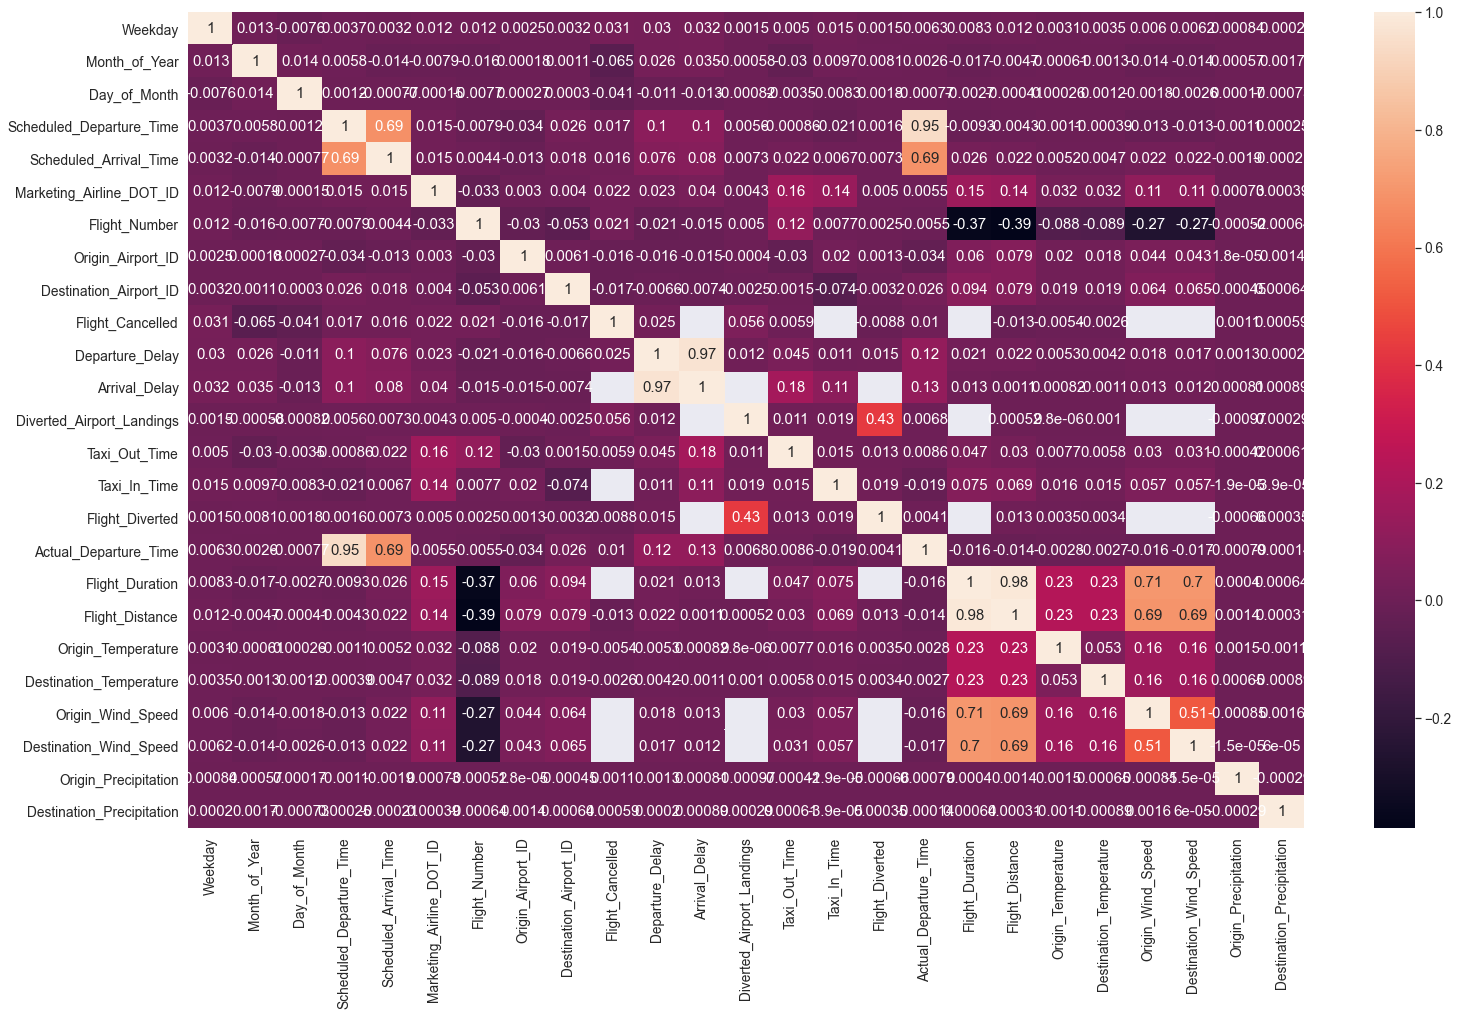

In [147]:
plt.figure(figsize=(25,15))
sns.set(font_scale=1.25)
sns.heatmap(train_data.corr(), annot=True)
plt.show()

#  Check Variance Inflation Factor (VIF) ???


### Interpretation:

- **Strong Positive Correlated variables:**

1. Scheduled_Departure_Time and Actual_Departure_Time: has a  positive correlation (0.95) between scheduled and actual departure times indicates that flights tend to depart close to their scheduled times.

2. Flight_Duration and Flight_Distance: has a strong positive correlation (0.98) between flight duration and flight distance, which is expected since longer flights cover greater distances.

3. Depature_Delay and Arrival_Delay: has a strong positive correlation (0.97), as Departure Delay increases, there is a strong tendency for Arrival Delay to also increase proportionally.



- **Weak Correlations:**
1. Month_of_Year and Flight_Cancelled: There is a weak negative correlation (-0.065) between the month of the year and flight cancellations, suggesting that flight cancellations might vary slightly across different months.
2. Scheduled_Departure_Time and Day_of_Month: The correlation (0.001) between departure time and day of the month is very weak, indicating little relationship between these variables.

When using regression machine learning models, it's recommended to exclude highly correlated variables to prevent issues related to multicollinearity. Multicollinearity arises when independent variables in a regression model exhibit strong correlations among themselves, which can hinder the model's ability to discern the individual impacts of these variables on the target outcome.

In this scenario, excluding the variable "Flight_Duration" and "Scheduled_Departure_Time" can help mitigate potential issues related to multicollinearity. By removing those variables, we decrease the redundancy in information shared with "Flight_Distance" and "Actual_Departure_Time". This will lead to enabling the regression models to more accurately capture the distinct contributions of each independent variable to predicting the target outcome. Keeping "Flight_Distance" is fundamental predictor of flight time and can directly influence arrival delays, whereas flight distance might be redundant given its strong correlation with flight distance. In addition, "Actual_Departure_Time" is likely more informative for predicting delays as it reflects actual depature time observed in real world scenarios.

By omitting those two variables, the regression models can more effectively evaluate the influence of other independent variables on the target outcome, resulting in more dependable and interpretable predictions.

### Dropping irrelevant variables / Feature selection 

In [148]:
train_data = train_data.drop(columns=['Flight_Number','Marketing_Airline_DOT_ID','Origin_Airport_ID','Destination_Airport_ID','Scheduled_Departure_Time','Flight_Duration'], axis=1)
test_data = test_data.drop(columns=['Flight_Number','Marketing_Airline_DOT_ID','Origin_Airport_ID','Destination_Airport_ID','Scheduled_Departure_Time','Flight_Duration'], axis=1)

### Data imputation and removing outliers

#### For numerical variables:
- Mean statistic globally was used to impute numerical variables


In [149]:
numerical_columns = train_data.select_dtypes(include=['int64', 'float64']).columns

# Calculate the IQR for each feature to identify outliers
Q1 = train_data[numerical_columns].quantile(0.25)
Q3 = train_data[numerical_columns].quantile(0.75)
IQR = Q3 - Q1

# Determine the threshold for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Replace outliers and impute null values with median
for feature in numerical_columns:
    median_value = train_data[feature].median()
    train_data.loc[train_data[feature].isnull() | (train_data[feature] < lower_bound[feature]) | (train_data[feature] > upper_bound[feature]), feature] = median_value


In [150]:
numerical_columns = test_data.select_dtypes(include=['int64', 'float64']).columns

# Calculate the IQR for each feature to identify outliers
Q1 = test_data[numerical_columns].quantile(0.25)
Q3 = test_data[numerical_columns].quantile(0.75)
IQR = Q3 - Q1

# Determine the threshold for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Replace outliers and impute null values with median
for feature in numerical_columns:
    median_value = test_data[feature].median()
    test_data.loc[test_data[feature].isnull() | (test_data[feature] < lower_bound[feature]) | (test_data[feature] > upper_bound[feature]), feature] = median_value


#### For categorical data
- Filling missing data with unknown as new category

In [151]:
train_data['Marketing_Airline'].unique()

array(['B6', nan, 'DL', 'AA', 'WN', 'UA', 'G4', 'NK', 'AS', 'F9', 'HA'],
      dtype=object)

In [152]:
test_data['Marketing_Airline'].unique()

array(['AA', nan, 'DL', 'UA', 'NK', 'WN', 'B6', 'F9', 'AS', 'G4', 'HA'],
      dtype=object)

In [153]:
train_data['Marketing_Airline'].fillna('missing', inplace=True)
test_data['Marketing_Airline'].fillna('missing', inplace=True)


In [154]:
train_data.isnull().sum()

Weekday                      0
Month_of_Year                0
Day_of_Month                 0
Scheduled_Arrival_Time       0
Marketing_Airline            0
Flight_Cancelled             0
Departure_State              0
Arrival_State                0
Departure_Delay              0
Arrival_Delay                0
Diverted_Airport_Landings    0
Taxi_Out_Time                0
Taxi_In_Time                 0
Flight_Diverted              0
Actual_Departure_Time        0
Flight_Distance              0
Origin_Temperature           0
Destination_Temperature      0
Origin_Wind_Speed            0
Destination_Wind_Speed       0
Origin_Precipitation         0
Destination_Precipitation    0
dtype: int64

In [155]:
test_data.isnull().sum()

Weekday                      0
Month_of_Year                0
Day_of_Month                 0
Scheduled_Arrival_Time       0
Marketing_Airline            0
Flight_Cancelled             0
Departure_State              0
Arrival_State                0
Departure_Delay              0
Diverted_Airport_Landings    0
Taxi_Out_Time                0
Taxi_In_Time                 0
Flight_Diverted              0
Actual_Departure_Time        0
Flight_Distance              0
Origin_Temperature           0
Destination_Temperature      0
Origin_Wind_Speed            0
Destination_Wind_Speed       0
Origin_Precipitation         0
Destination_Precipitation    0
dtype: int64

## Data visualization after preprocessing 

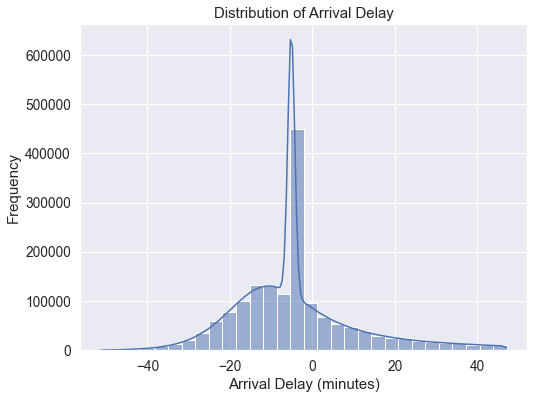

In [156]:
# Visualize distribution of target variable
plt.figure(figsize=(8, 6))
sns.histplot(train_data["Arrival_Delay"], bins=30, kde=True)
plt.xlabel("Arrival Delay (minutes)")
plt.ylabel("Frequency")
plt.title("Distribution of Arrival Delay")
plt.show()

<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


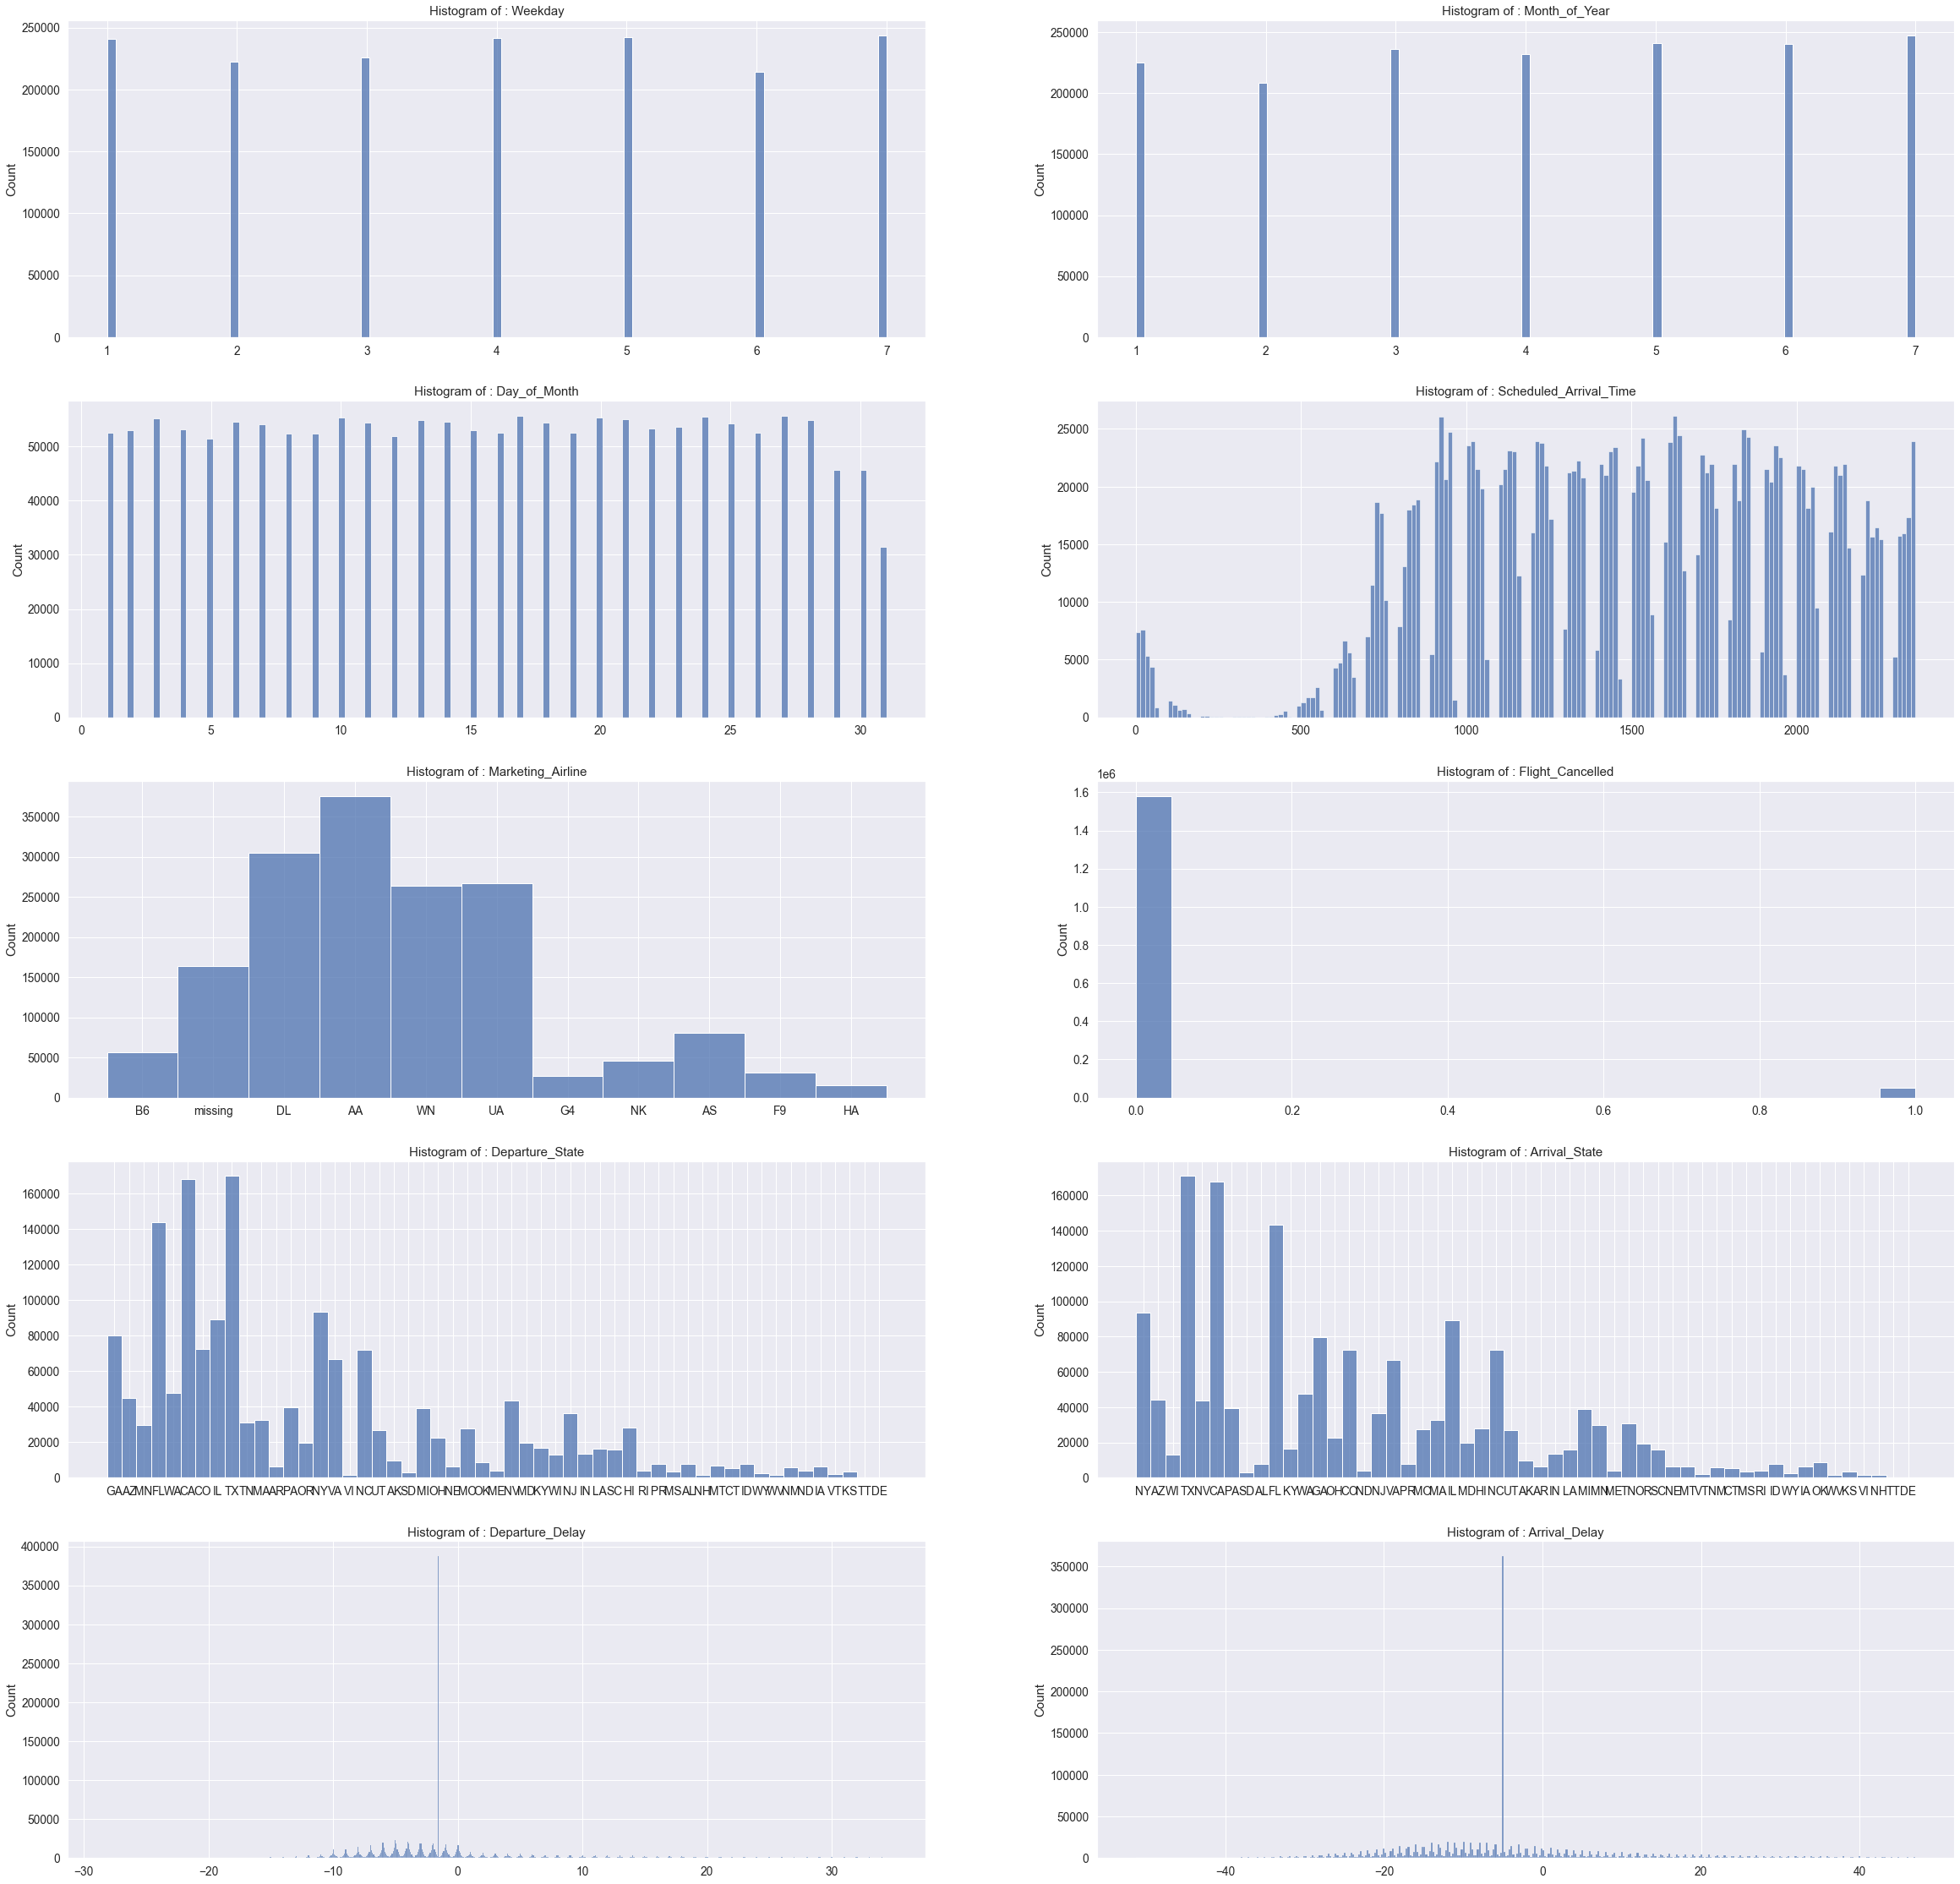

In [157]:
fig, axes = plt.subplots(ncols=2, nrows=5, figsize=(40, 40))
for i, ax in zip(train_data.columns, axes.flat):
    sns.histplot(x=train_data[i], ax=ax).set(title=f"Histogram of : {i}", xlabel="")
plt.show()

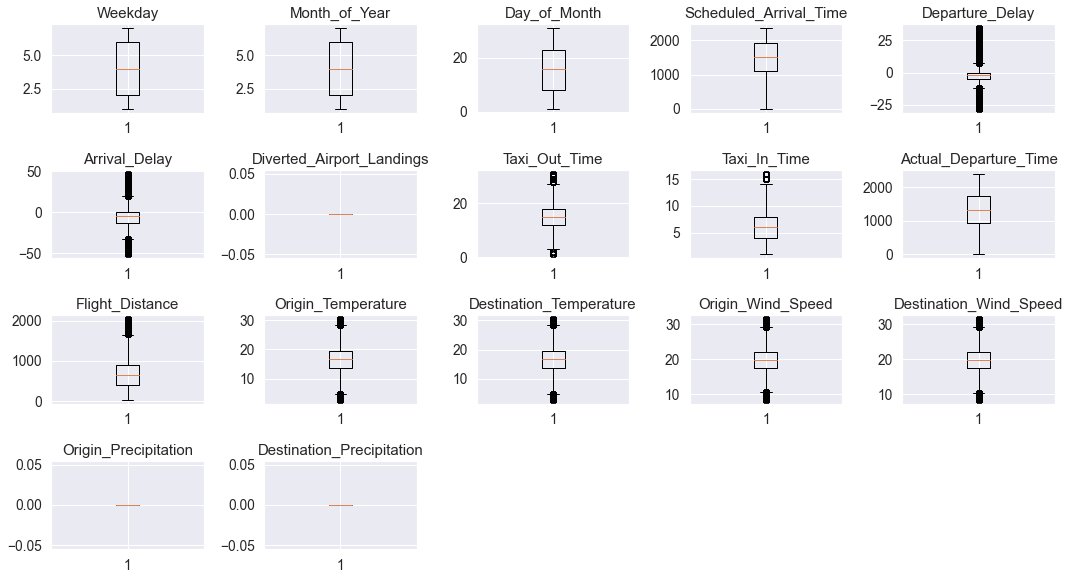

In [158]:
# Select only numerical columns for boxplot
numerical_columns = train_data.select_dtypes(include=['int64', 'float64']).columns

# Plot boxplots for each numerical column
plt.figure(figsize=(15, 10))  # Adjust figure size as needed

for i, column in enumerate(numerical_columns, start=1):
    plt.subplot(5, 5, i)  # Adjust subplot layout based on the number of columns
    plt.boxplot(train_data[column])  # Plot boxplot for each column
    plt.title(column)  # Set title as column name
    plt.grid(True)  # Add grid for better visualization

plt.tight_layout()  # Adjust subplot layout for better spacing
plt.show()

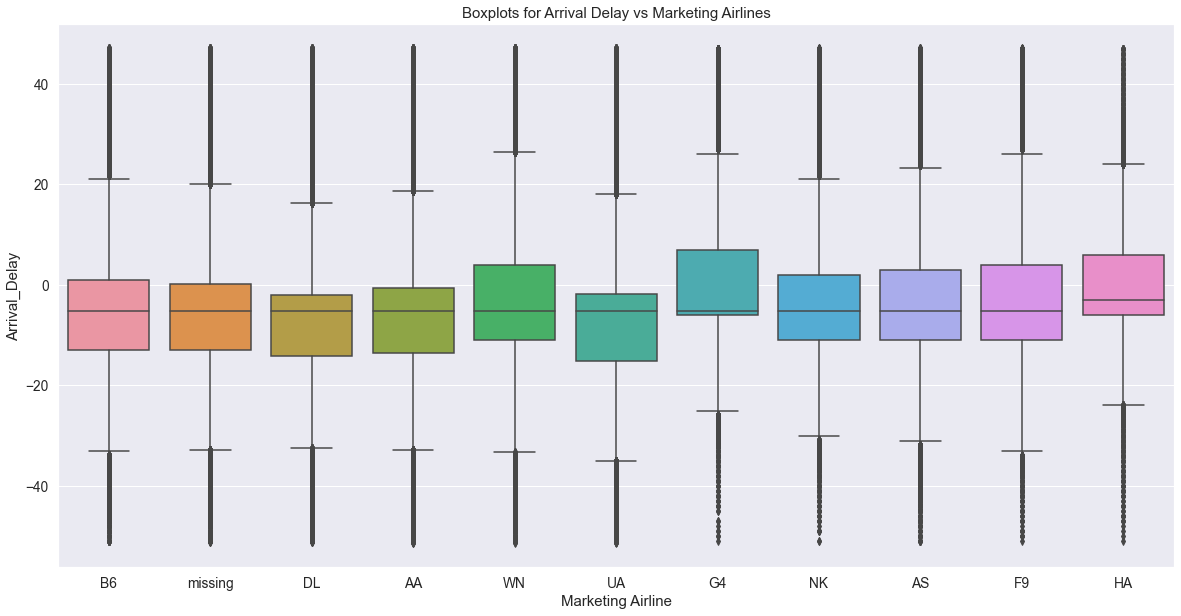

In [159]:
plt.figure(figsize=(20, 10))
sns.boxplot(x=train_data.Marketing_Airline, y=train_data.Arrival_Delay).set(
    title="Boxplots for Arrival Delay vs Marketing Airlines", xlabel="Marketing Airline"
)
plt.show()

### Correlation of the variables 

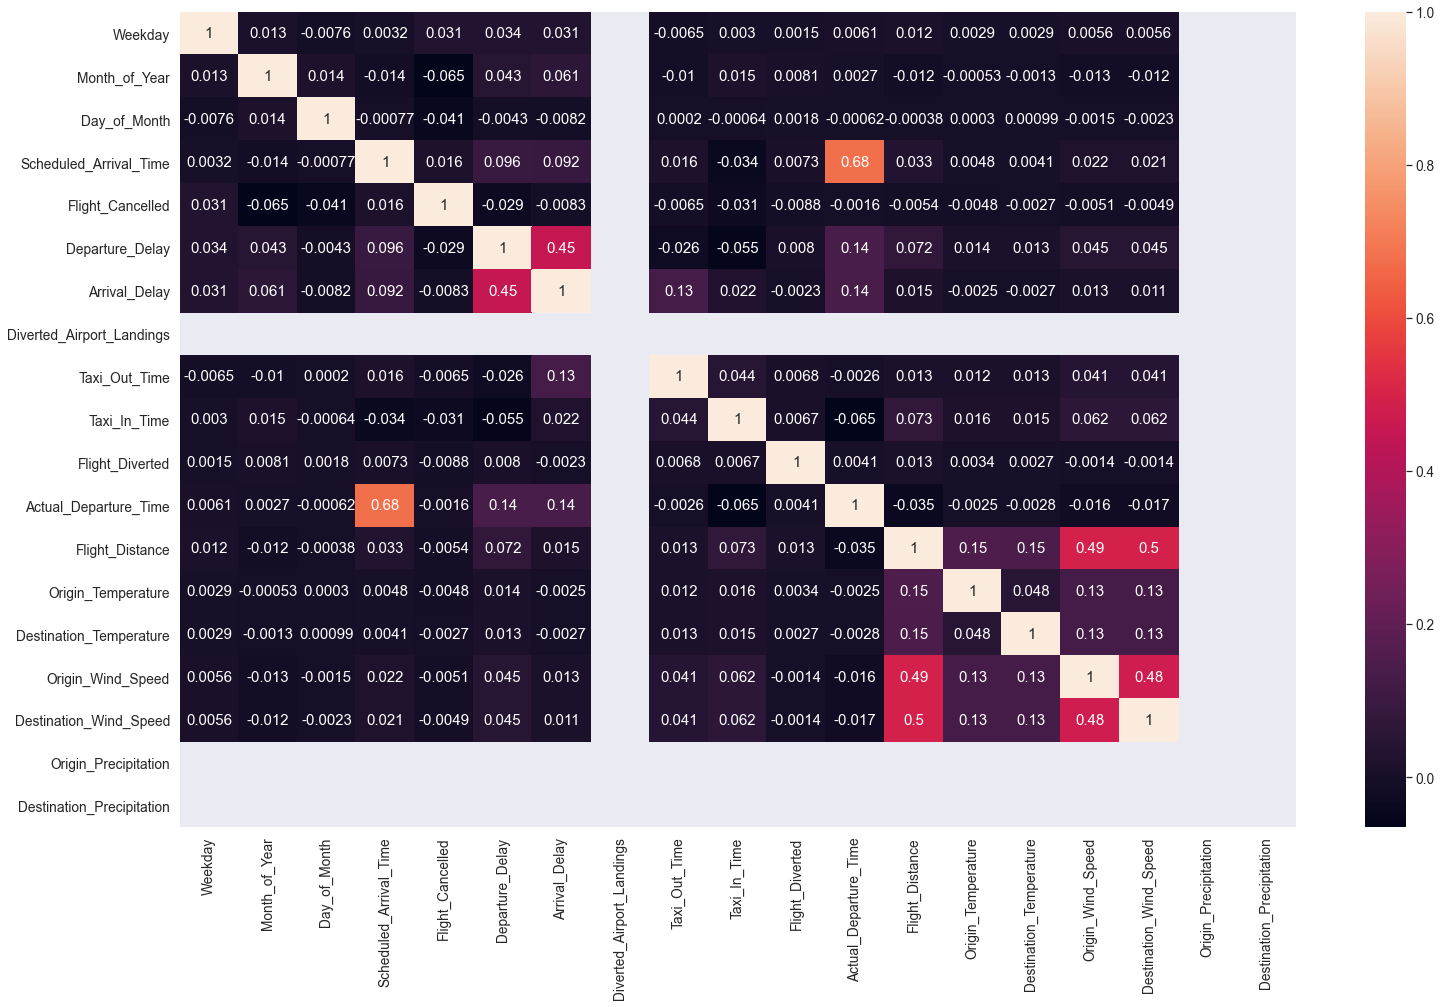

In [160]:
plt.figure(figsize=(25,15))
sns.set(font_scale=1.25)
sns.heatmap(train_data.corr(), annot=True)
plt.show()

### Econding

In [161]:
train_data['Arrival_State'].unique()

array(['NY', 'AZ', 'WI', 'TX', 'NV', 'CA', 'PA', 'SD', 'AL', 'FL', 'KY',
       'WA', 'GA', 'OH', 'CO', 'ND', 'NJ', 'VA', 'PR', 'MO', 'MA', 'IL',
       'MD', 'HI', 'NC', 'UT', 'AK', 'AR', 'IN', 'LA', 'MI', 'MN', 'ME',
       'TN', 'OR', 'SC', 'NE', 'MT', 'VT', 'NM', 'CT', 'MS', 'RI', 'ID',
       'WY', 'IA', 'OK', 'WV', 'KS', 'VI', 'NH', 'TT', 'DE'], dtype=object)

In [162]:
train_data['Departure_State'].unique()

array(['GA', 'AZ', 'MN', 'FL', 'WA', 'CA', 'CO', 'IL', 'TX', 'TN', 'MA',
       'AR', 'PA', 'OR', 'NY', 'VA', 'VI', 'NC', 'UT', 'AK', 'SD', 'MI',
       'OH', 'NE', 'MO', 'OK', 'ME', 'NV', 'MD', 'KY', 'WI', 'NJ', 'IN',
       'LA', 'SC', 'HI', 'RI', 'PR', 'MS', 'AL', 'NH', 'MT', 'CT', 'ID',
       'WY', 'WV', 'NM', 'ND', 'IA', 'VT', 'KS', 'TT', 'DE'], dtype=object)

In [163]:
train_data['Marketing_Airline'].unique()

array(['B6', 'missing', 'DL', 'AA', 'WN', 'UA', 'G4', 'NK', 'AS', 'F9',
       'HA'], dtype=object)

Enconding those variables will increase dimension of the dataset, should it really be considered? then I could apply pca or just drop them?? not sure first let me check result without them then decided

In [164]:
# # # Encode categorical variables (one-hot encoding)
# train_data = pd.get_dummies(train_data, columns=['Marketing_Airline', 'Departure_State', 'Arrival_State'])
# test_data = pd.get_dummies(test_data, columns=['Marketing_Airline', 'Departure_State', 'Arrival_State'])

In [166]:
# Define the columns to be target encoded
columns_to_encode = ['Marketing_Airline', 'Departure_State', 'Arrival_State']

# Initialize the TargetEncoder
encoder = ce.TargetEncoder(cols=columns_to_encode)

# Fit the encoder on the training data and transform both training and validation data
train_data_encoded = encoder.fit_transform(train_data[columns_to_encode], train_data['Arrival_Delay'])
test_data_encoded = encoder.transform(test_data[columns_to_encode])

# Merge the encoded features with the original data
train_data = pd.concat([train_data.drop(columns=columns_to_encode), train_data_encoded], axis=1)
test_data = pd.concat([test_data.drop(columns=columns_to_encode), test_data_encoded], axis=1)


In [167]:
train_data.head()

,Weekday,Month_of_Year,Day_of_Month,Scheduled_Arrival_Time,Flight_Cancelled,Departure_Delay,Arrival_Delay,Diverted_Airport_Landings,Taxi_Out_Time,Taxi_In_Time,...,Flight_Distance,Origin_Temperature,Destination_Temperature,Origin_Wind_Speed,Destination_Wind_Speed,Origin_Precipitation,Destination_Precipitation,Marketing_Airline,Departure_State,Arrival_State
0,6.0,6.0,25.0,1444.0,False,-1.571396,-5.111228,0.0,16.0,10.0,...,760.0,25.140220,19.357739,21.019808,15.452723,0.0,0.0,-4.039454,-3.616913,-4.756624
1,2.0,6.0,21.0,1304.0,False,0.088687,-4.178483,0.0,16.0,5.0,...,110.0,13.279939,20.470690,18.045064,12.910265,0.0,0.0,-4.416473,-3.247405,-4.875353
2,3.0,1.0,5.0,2055.0,False,-1.571396,5.042185,0.0,15.0,5.0,...,119.0,17.816202,13.967273,21.606228,17.976362,0.0,0.0,-6.050021,-5.869375,-3.882969
3,2.0,3.0,22.0,924.0,False,-1.802698,-0.206932,0.0,10.0,11.0,...,641.0,24.562566,14.509228,24.946489,22.630553,0.0,0.0,-4.984966,-3.140161,-5.142967
4,4.0,7.0,14.0,2359.0,False,-1.571396,14.006092,0.0,23.0,7.0,...,867.0,8.817992,10.866812,17.426336,17.401007,0.0,0.0,-4.416473,-4.455899,-2.726526


In [ ]:
# test_data = test_data.drop(columns=['Marketing_Airline', 'Departure_State', 'Arrival_State'], axis=1)
# train_data = train_data.drop(columns=['Marketing_Airline', 'Departure_State', 'Arrival_State'], axis=1)

### Scaling

In [169]:
# Define the features for scaling
train_features = ['Scheduled_Arrival_Time','Actual_Departure_Time','Departure_Delay','Taxi_Out_Time','Taxi_In_Time','Flight_Distance','Origin_Temperature','Destination_Temperature','Origin_Wind_Speed','Destination_Wind_Speed']


# Create a scaler and apply scaling
scaler = StandardScaler()
train_data[train_features] = scaler.fit_transform(train_data[train_features])

In [170]:
round(train_data.describe().T,2)

,count,mean,std,min,25%,50%,75%,max
Weekday,1631327.0,4.01,2.01,1.00,2.00,4.00,6.00,7.00
Month_of_Year,1631327.0,4.08,2.00,1.00,2.00,4.00,6.00,7.00
Day_of_Month,1631327.0,15.72,8.76,1.00,8.00,16.00,23.00,31.00
Scheduled_Arrival_Time,1631327.0,0.00,1.00,-2.86,-0.74,0.05,0.84,1.68
Departure_Delay,1631327.0,0.00,1.00,-3.29,-0.55,-0.17,0.02,4.06
Arrival_Delay,1631327.0,-4.42,14.76,-51.30,-13.02,-5.11,0.17,47.07
Diverted_Airport_Landings,1631327.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Taxi_Out_Time,1631327.0,-0.00,1.00,-2.77,-0.62,-0.04,0.55,3.08
Taxi_In_Time,1631327.0,-0.00,1.00,-1.83,-0.84,-0.18,0.49,3.13
Actual_Departure_Time,1631327.0,-0.00,1.00,-2.68,-0.82,-0.02,0.81,2.14


In [171]:
# Define the features for scaling
test_features = ['Scheduled_Arrival_Time','Actual_Departure_Time','Departure_Delay','Taxi_Out_Time','Taxi_In_Time','Flight_Distance','Origin_Temperature','Destination_Temperature','Origin_Wind_Speed','Destination_Wind_Speed']


# Create a scaler and apply scaling
scaler = StandardScaler()
test_data[test_features] = scaler.fit_transform(test_data[test_features])

In [172]:
round(test_data.describe().T,2)

,count,mean,std,min,25%,50%,75%,max
Weekday,407832.0,4.01,2.01,1.00,2.00,4.00,6.00,7.00
Month_of_Year,407832.0,4.09,2.00,1.00,2.00,4.00,6.00,7.00
Day_of_Month,407832.0,15.73,8.76,1.00,8.00,16.00,23.00,31.00
Scheduled_Arrival_Time,407832.0,0.00,1.00,-2.87,-0.74,0.05,0.84,1.68
Departure_Delay,407832.0,0.00,1.00,-3.37,-0.56,-0.16,0.01,4.07
Diverted_Airport_Landings,407832.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Taxi_Out_Time,407832.0,0.00,1.00,-2.76,-0.62,-0.04,0.55,3.08
Taxi_In_Time,407832.0,0.00,1.00,-1.83,-0.84,-0.18,0.48,3.13
Actual_Departure_Time,407832.0,-0.00,1.00,-2.67,-0.82,-0.02,0.81,2.14
Flight_Distance,407832.0,0.00,1.00,-1.66,-0.74,-0.12,0.54,3.41


## Regression models

We developed 9  distinct regression models to explore various regression algorithms.

- Initially, we split the training dataset into two subsets: 80% for training and 20% for validation. This division ensured distinct datasets for training and evaluating model performance.


- Several regression algorithms are defined, including Linear Regression, Ridge Regression, ElasticNet, Lasso Regression, XGBoost Regressor, Decision Tree Regressor, Support Vector Regressor (with linear, polynomial, and radial basis function kernels), K-Nearest Neighbors Regressor, and Multi-layer Perceptron Regressor.

- Each algorithm is associated with a parameter grid for hyperparameter tuning.

- Each model was trained using the training dataset, where we fit them with the training features and corresponding target values. This process enabled the models to learn the underlying patterns and relationships within the data.


- Grid search is performed to find the best hyperparameters using 5-fold cross-validation on the training data.


- Post-training, we utilized the validation features to generate predictions for the corresponding target values. By comparing these predictions with the actual target values in the validation set, we computed the Mean Absolute Percentage Error (MAPE) to evaluate model accuracy.



- Moreover, the code incorporates a step where the trained models were used to predict the target variable for the test dataset. These predictions were saved in distinct CSV files for each model.

- The best parameters and scores for each algorithm are saved to a DataFrame and exported to a CSV file (best_parameters_scores.csv).

- Additionally, the MAPE on the validation set for each algorithm is stored in a results dictionary.

- At the end of execution, the MAPE on the validation set for each algorithm is printed.

Following these procedures allowed us to evaluate the performance of various linear regression models, identify the model with the lowest MAPE on the validation set, and generate predictions for the test dataset.

In [ ]:
# # Define the features and target variable
# target = 'Arrival_Delay'
# features = train_data.drop(columns=[target]).columns.tolist()

# # Split the data into training and validation sets
# train_df, val_df = train_test_split(train_data, test_size=0.2, random_state=123)

# # Separate features and target for training, validation, and testing
# X_train = train_df[features]
# y_train = train_df[target]
# X_val = val_df[features]
# y_val = val_df[target]
# X_test = test_data[features]

# # Define the regression algorithms
# algorithms = [
#     LinearRegression(),
#     Ridge(alpha=0.5, random_state=123),
#     ElasticNet(alpha=0.5,_ratio=0.5),
#     Lasso(alpha=0.5, random_state=123),
#     xgb.XGBRegressor()
# ]

# # Iterate over the algorithms and print the MAPE and Cross Validation results
# for algorithm in algorithms:
#     model_name = algorithm.__class__.__name__
#     model = algorithm
#     model.fit(X_train, y_train)
#     val_predictions = model.predict(X_val)
#     mape = mean_absolute_percentage_error(y_val, val_predictions)

#     cv_scores = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_absolute_percentage_error')
#     mean_cv_mape = -cv_scores.mean()

#     print(f"{model_name} Cross-Validation MAPE: {mean_cv_mape:.2f}, {model_name} MAPE on validation set: {mape :.2f}")
    
#     # Predict test data and save the predictions as separate CSV files
#     test_predictions = model.predict(X_test)
    
#     # Create a DataFrame with the predictions
#     predictions_df = pd.DataFrame({model_name: test_predictions})
    


In [176]:
# Define the features and target variable
target = 'Arrival_Delay'
features = train_data.drop(columns=[target]).columns.tolist()

# Split the data into training, validation, and testing sets
train_df, val_df = train_test_split(train_data, test_size=0.2, random_state=123)
X_train = train_df[features]
y_train = train_df[target]
X_val = val_df[features]
y_val = val_df[target]
X_test = test_data[features]

# Define the regression algorithms
algorithms = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "ElasticNet": ElasticNet(),
    "Lasso": Lasso(),
    "XGBRegressor": xgb.XGBRegressor(),
    "DecisionTreeRegressor": DecisionTreeRegressor(),
    # "RandomForestRegressor": RandomForestRegressor(), #takes forever to run
    "SVR_linear": SVR(kernel='linear'),
    "SVR_poly": SVR(kernel='poly'),
    "SVR_rbf": SVR(kernel='rbf'),
    "KNN": KNeighborsRegressor(),
    "MLPRegressor": MLPRegressor()
}

# Define the parameter grid for each algorithm
param_grids = {
    "LinearRegression": {},
    "Ridge": {'alpha': [0.1, 1.0, 10.0]},
    "ElasticNet": {'alpha': [0.1, 1.0, 10.0], 'l1_ratio': [0.25, 0.5, 0.75]},
    "Lasso": {'alpha': [0.1, 1.0, 10.0]},
    "XGBRegressor": {'n_estimators': [100, 200, 300], 'max_depth': [3, 5, 7]},
    "DecisionTreeRegressor": {'max_depth': [3, 5, 7]},
    # "RandomForestRegressor": {'n_estimators': [100, 200, 300], 'max_depth': [3, 5, 7]},
    "SVR_linear": {'C': [0.1, 1.0, 10.0], 'epsilon': [0.01, 0.1, 1.0]},
    "SVR_poly": {'C': [0.1, 1.0, 10.0], 'epsilon': [0.01, 0.1, 1.0], 'degree': [2, 3, 4]},
    "SVR_rbf": {'C': [0.1, 1.0, 10.0], 'epsilon': [0.01, 0.1, 1.0], 'gamma': ['scale', 'auto']},
    "KNN": {'n_neighbors': [3, 5, 7]},
    "MLPRegressor": {'hidden_layer_sizes': [(100,), (50, 100), (50, 50, 50)], 'alpha': [0.0001, 0.001, 0.01]}
}

# Dictionary to store the best parameters, scores, and MAPE for each algorithm
results = {'Algorithm': [], 'MAPE on validation set': []}
# Dictionary to store the best parameters and scores for each algorithm
best_params = {}

# Iterate over the algorithms and perform hyperparameter tuning, grid search, and cross-validation
for name, algorithm in algorithms.items():
    print(f"Running {name}...")
    param_grid = param_grids[name]
    
    pipeline = algorithm
    
    # Perform grid search for hyperparameter tuning
    grid_search = GridSearchCV(pipeline, param_grid, scoring='neg_mean_absolute_percentage_error', cv=5)
    grid_search.fit(X_train, y_train)
    
    # or use random search
     # Perform randomized search for hyperparameter tuning
    # randomized_search = RandomizedSearchCV(pipeline, param_grid, n_iter=10, scoring='neg_mean_absolute_percentage_error', cv=5)
    # randomized_search.fit(X_train, y_train)
    

    # Store the best parameters and scores
    best_params[name] = {
        'best_parameters': grid_search.best_params_,
        'best_score': -1 * grid_search.best_score_
    }
    
    # Print the best parameters and scores
    print("Best Parameters:", best_params[name]['best_parameters'])
    print("Best Score:", best_params[name]['best_score'])

    results['Algorithm'].append(name)

    # Perform cross-validation and calculate MAPE on the validation set
    cv_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=5, scoring='neg_mean_absolute_percentage_error')
    mean_cv_mape = -cv_scores.mean()
    print(f"{name} Cross-Validation MAPE: {mean_cv_mape:.2f}")
    
    
    # Train the model on the full training data with the best parameters
    model = grid_search.best_estimator_
    model.fit(X_train, y_train)

    # Predict test data and save the predictions as separate CSV files
    test_predictions = model.predict(X_test)
    
    # Create a DataFrame with the predictions
    predictions_df = pd.DataFrame({name: test_predictions})
    
    # Save the predictions to a CSV file
    predictions_df.to_csv(f'data\output\{name}_predictions.csv', index=False)
    

    val_predictions = model.predict(X_val)
    val_mape = mean_absolute_percentage_error(y_val, val_predictions)
    print(f"{name} MAPE on validation set: {val_mape:.2f}")
    results['MAPE on validation set'].append(val_mape)
 
    print()

# Save best parameters and scores to a DataFrame
best_params_df = pd.DataFrame(best_params)
best_params_df.to_csv('data\output\best_parameters_scores.csv', index=False)

Running LinearRegression...
Best Parameters: {}
Best Score: 11.423804203727107
LinearRegression Cross-Validation MAPE: 11.43
LinearRegression MAPE on validation set: 8.42

Running Ridge...
Best Parameters: {'alpha': 10.0}
Best Score: 11.423735053593527
Ridge Cross-Validation MAPE: 11.43
Ridge MAPE on validation set: 8.42

Running ElasticNet...
Best Parameters: {'alpha': 1.0, 'l1_ratio': 0.25}
Best Score: 9.042844243144936
ElasticNet Cross-Validation MAPE: 9.06
ElasticNet MAPE on validation set: 7.50

Running Lasso...
Best Parameters: {'alpha': 0.1}
Best Score: 11.515642660776093
Lasso Cross-Validation MAPE: 11.52
Lasso MAPE on validation set: 8.39

Running XGBRegressor...
Best Parameters: {'max_depth': 5, 'n_estimators': 100}
Best Score: 11.406899048654601
XGBRegressor Cross-Validation MAPE: 11.35
XGBRegressor MAPE on validation set: 9.06

Running DecisionTreeRegressor...
Best Parameters: {'max_depth': 7}
Best Score: 14.107207138805796
DecisionTreeRegressor Cross-Validation MAPE: 14.13

- The results dictionary, which contains the MAPE on the validation set for each algorithm, is converted into a DataFrame named results_df.

- The results_df DataFrame is saved to a CSV file named 'algorithm_comparison_results.csv'. This file contains the MAPE on the validation set for each algorithm.


A horizontal bar plot is created using Matplotlib (matplotlib.pyplot) to visualize the MAPE on the validation set for each algorithm. The algorithm names are plotted on the y-axis, and their corresponding MAPE values are plotted on the x-axis.

In [ ]:
# Convert results dictionary to DataFrame
results_df = pd.DataFrame(results)

# Save results to a CSV file
results_df.to_csv('data\output\algorithm_comparison_results.csv', index=False)

# Plotting barplot of MAPE on test set for each algorithm
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(results_df['Algorithm'], results_df['MAPE on validation sett'], color='skyblue')
plt.xlabel('MAPE on validation set')
plt.title('Comparison of Models: MAPE on validation set')
plt.gca().invert_yaxis()
plt.show()

## Summary

1. Both Linear Regression and Ridge Regression have similar performance, with Ridge Regression slightly outperforming Linear Regression.
The MAPE on the validation set for both models is approximately 8.42%, indicating a moderate level of accuracy.


2. ElasticNet Regression performed better than Linear and Ridge Regression, with a MAPE of approximately 7.50% on the validation set.
It selected an alpha value of 1.0 and an L1 ratio of 0.25 as the best hyperparameters, which suggests a balance between L1 (Lasso) and L2 (Ridge) regularization.

3. Lasso Regression yielded a slightly higher MAPE on the validation set compared to ElasticNet and Ridge Regression, approximately 8.39%.
It selected an alpha value of 0.1 as the best hyperparameter, indicating stronger regularization.

4. XGBRegressor, a gradient boosting algorithm, showed similar performance to Linear and Ridge Regression, with a MAPE of approximately 9.06% on the validation set.
It selected a max depth of 5 and 100 estimators as the best hyperparameters.


5. The Decision Tree Regressor exhibited the highest MAPE on the validation set among the tested algorithms, approximately 11.11%.
It selected a max depth of 7 as the best hyperparameter.



add more and fix issue of long runtime !!!!!!!!!!!!!!!

## Conclusion

## Refrences 

[1] https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/

[2] https://medium.com/@alihijazy/hyperparameters-in-regression-models-a-quick-dive-785b4a56bd2b

[3] https://pieriantraining.com/7-machine-learning-regression-algorithms-python/

[4] https://www.geeksforgeeks.org/regression-in-machine-learning/

[5] https://www.datacamp.com/tutorial/categorical-data